# Data Cleaning

Preparing SaverLife Saver Transaction History Data for [AWS RDS](https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/Welcome.html)

*Note*: Assumes [`xlrd`](https://xlrd.readthedocs.io/en/latest/) is installed

In [3]:
import pandas as pd

class Transactions:
    """
    SaverLife Savers Transaction Data
    """

    def __init__(self, parent_grandparent_categories, transaction_data_tables):
        """
        Initialize Transactions class with data inputs

        Args:
            parent_grandparent_categories: Plaid API transaction categories
            transaction_data_tables: Plaid transaction data (stored as XLSX file)        
        """

        self.parent_grandparent_categories = parent_grandparent_categories
        self.transaction_data_tables = transaction_data_tables
        
    def clean_and_save(self, output_file):
        """ 
        Method to merge/clean transaction data tables and save to file
        
        Args:
            output_file: Local file path to save cleaned transction data

        Returns:
            Success statement upon completion of save 
        """

        self.output_file = output_file

        # Initialize list with features of interest to select from categories data
        self.category_categories_of_interest = ["plaid_category_id",
                                                "category_name",
                                                "parent_category_name",
                                                "grandparent_category_name"]
        
        self.BA_categories_of_interest = ["id","current_balance_cents", 
                                          "updated_at",
                                          "created_at",
                                          "name",
                                          "account_subtype",
                                          "plaid_account_id", 
                                          "plaid_financial_authentication_id", 
                                          "available_balance_cents", 
                                          "initial_balance_cents"]
        
        self.PFA_categories_of_interest = ["id",
                                           "institution_name",
                                           "user_id",
                                           "updated_at",
                                           "created_at",
                                           "last_status_update_at"]
        
        self.PMT_categories_of_interest = ["category_id",
                                           "plaid_account_id", 
                                           "bank_account_id", 
                                           "id", 
                                           "amount_cents", 
                                           "purpose",
                                           "date", 
                                           "created_at", 
                                           "updated_at"]
        
        # Read PFA sheet of transaction_data_tables Excel notebook, dropping duplicates
        self.PFA = pd.read_excel(self.transaction_data_tables, 
                                 "PFA").drop_duplicates()
        self.PFA = self.PFA.copy()
        self.PFA = self.PFA[self.PFA_categories_of_interest]
        
        # Read BA sheet of transaction_data_tables Excel notebook, dropping duplicates
        self.BA = pd.read_excel(self.transaction_data_tables, 
                                "BA").drop_duplicates()
        self.BA = self.BA.copy()
        self.BA = self.BA[self.BA_categories_of_interest]
        
        # Read PMT sheet of transaction_data_tables Excel notebook
        self.PMT = pd.read_excel(self.transaction_data_tables, 
                                 "PMT")
        self.PMT = self.PMT.copy()
        self.PMT_subset = self.PMT[self.PMT_categories_of_interest]

        # Read category data using pandas `read_csv` function
        self.categories = pd.read_csv(self.parent_grandparent_categories)
        self.categories = self.categories.copy()
        self.categories = self.categories[self.category_categories_of_interest]
        
        # Merge PMT table with Plaid spending categories
        self.PMT_categories = pd.merge(self.PMT_subset, 
                                       self.categories, 
                                       left_on="category_id", 
                                       right_on="plaid_category_id")
        
        # Merge PMT_categories with BA table
        self.PMT_categories_BA = pd.merge(self.PMT_categories, 
                                          self.BA, 
                                          left_on="bank_account_id", 
                                          right_on="id",
                                          suffixes=("", "_BA"))
        
        # Merge PMT_categories_BA with PFA table
        self.PMT_categories_BA_PFA = pd.merge(self.PMT_categories_BA, 
                                              self.PFA, 
                                              left_on="plaid_financial_authentication_id", 
                                              right_on="id", suffixes=("_PMT", "_PFA"))
        
        # Save PMT_categories_BA_PFA to local CSV file at output_file (probably change to to_json or to_sql)
        #self.PMT_categories_BA_PFA.to_csv(self.output_file)

        # Return success statement to inform user of completion
        print("It worked")

In [4]:
test = Transactions(".\parent_grandparent_categories copy.csv", ".\PFA_BA_PMT_Table_examples.xlsx")

test.clean_and_save("")

FileNotFoundError: [Errno 2] No such file or directory: '.\\PFA_BA_PMT_Table_examples.xlsx'

In [162]:
test.PMT_categories_BA_PFA

,category_id,plaid_account_id,bank_account_id,id_PMT,amount_cents,purpose,date,created_at_PMT,updated_at_PMT,plaid_category_id,...,plaid_account_id_BA,plaid_financial_authentication_id,available_balance_cents,initial_balance_cents,id_PFA,institution_name,user_id,updated_at_PFA,created_at_PFA,last_status_update_at
0,21006000,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,132151,38192796,38743,withdrawal,2020-08-05 07:00:00,2020-08-06 02:36:05.186,2020-08-06 02:36:05.186,21006000.0,...,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,56537,0,0,56537,Chime,240359,2020-08-06 02:41:06.562,2020-03-09 19:30:16.038,2020-08-06 02:41:06.591
1,21006000,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,132151,38192795,8000,withdrawal,2020-08-05 07:00:00,2020-08-06 02:36:05.164,2020-08-06 02:36:05.164,21006000.0,...,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,56537,0,0,56537,Chime,240359,2020-08-06 02:41:06.562,2020-03-09 19:30:16.038,2020-08-06 02:41:06.591
2,21006000,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,132151,38192794,2500,withdrawal,2020-08-05 07:00:00,2020-08-06 02:36:05.146,2020-08-06 02:36:05.146,21006000.0,...,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,56537,0,0,56537,Chime,240359,2020-08-06 02:41:06.562,2020-03-09 19:30:16.038,2020-08-06 02:41:06.591
3,21006000,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,132151,13650663,42,withdrawal,2018-03-12 07:00:00,2020-03-09 19:30:28.909,2020-03-09 19:30:28.909,21006000.0,...,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,56537,0,0,56537,Chime,240359,2020-08-06 02:41:06.562,2020-03-09 19:30:16.038,2020-08-06 02:41:06.591
4,21006000,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,132151,13650661,2000,withdrawal,2018-04-02 07:00:00,2020-03-09 19:30:28.883,2020-03-09 19:30:28.883,21006000.0,...,kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b,56537,0,0,56537,Chime,240359,2020-08-06 02:41:06.562,2020-03-09 19:30:16.038,2020-08-06 02:41:06.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,21001000,XgAqyyoExpUvy0yX8Z3YH5ALX4x0aEf4kqq0q,133542,13946874,100,withdrawal,2019-10-07 07:00:00,2020-03-19 00:40:59.492,2020-03-19 00:40:59.492,21001000.0,...,XgAqyyoExpUvy0yX8Z3YH5ALX4x0aEf4kqq0q,57341,4,4,57341,Regions Bank,244279,2020-08-05 13:24:24.320,2020-03-19 00:40:50.010,2020-08-05 13:24:24.329
5208,21001000,XgAqyyoExpUvy0yX8Z3YH5ALX4x0aEf4kqq0q,133542,13946873,123,withdrawal,2019-10-16 07:00:00,2020-03-19 00:40:59.478,2020-03-19 00:40:59.478,21001000.0,...,XgAqyyoExpUvy0yX8Z3YH5ALX4x0aEf4kqq0q,57341,4,4,57341,Regions Bank,244279,2020-08-05 13:24:24.320,2020-03-19 00:40:50.010,2020-08-05 13:24:24.329
5209,21001000,XgAqyyoExpUvy0yX8Z3YH5ALX4x0aEf4kqq0q,133542,13946871,2,withdrawal,2020-02-21 08:00:00,2020-03-19 00:40:52.413,2020-03-19 00:40:52.413,21001000.0,...,XgAqyyoExpUvy0yX8Z3YH5ALX4x0aEf4kqq0q,57341,4,4,57341,Regions Bank,244279,2020-08-05 13:24:24.320,2020-03-19 00:40:50.010,2020-08-05 13:24:24.329
5210,21007000,XgAqyyoExpUvy0yX8Z3YH5ALX4x0aEf4kqq0q,133542,13946886,-25000,deposit,2019-02-20 08:00:00,2020-03-19 00:40:59.661,2020-03-19 00:40:59.661,21007000.0,...,XgAqyyoExpUvy0yX8Z3YH5ALX4x0aEf4kqq0q,57341,4,4,57341,Regions Bank,244279,2020-08-05 13:24:24.320,2020-03-19 00:40:50.010,2020-08-05 13:24:24.329


In [2]:
test.PMT_categories_BA_PFA['bank_account_id'].unique()

NameError: name 'test' is not defined

In [190]:
test.PMT_categories_BA_PFA["plaid_account_id"].unique()

array(['kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b',
       'rekPD6wxbPfEqbVbDpYZck38dan4K3sB8rx5n',
       'jZrge9o4XVcbdaxM78R5C7K6BrqD1MhRMdoym',
       'vq4mMRdZLeFon7bK63jefLOomaRPYBCmAJP6g',
       'vMr0dbz7qMFmmVkDbXEXTJkRz8P4netmY9jjj',
       'pRkakg38abt86wxvD380UAVNDE9XNAuJJ3Aor',
       'KnrQ0oNwd1C3RNPaEBbaIqNxge7gBXTQvyjvA',
       'prowokzo5PT6mzBPX3gRuDN6k1dr0aFJD14v6',
       'ALZLMwDdjmH3zXakq4BDFJ3zgX0roNU6bMEE6',
       '1E1L81Ld3RfgPL7XdkAZtZd7V169xXHmQROrv',
       'ojQ7ZARMD3HvOxe0AM7ZfgqByxymNgcBdErKK',
       'X1VPwkEJAzHBEaByOrmDHMoDQEJO5ws4OnkXy',
       '5AErXqkmRPiPy3xda15LIA1MYQwkx7f1wx65v',
       'mEQmv8ybP1t3o3bYnKzwFqP5jad1KKUM8N06o',
       '1635ob1dkQIz1QMjLmBpt0E36VyM96ImeyrgZ',
       'v37a5rODaRHkkBgZje0LFjLLVPYmr9fmzjr9D',
       'V34Dr53jNYCw3KgBE7L6uvBoaLKPk8traRgAZ',
       'Oj09YgyXX9h308gOwLjxiOXYZn8AmjC8ejqVj',
       'PrO6nDOgqru8qg6dQ5wOHjP3AzBJ9xtmrnYVM',
       'a58a97rVLZs6LZdYRn94sLvNR0jRq1IZL0pnq',
       'DgJqoXeN79hMVXB53XYBH4wJzPk0evUZ

In [155]:
test.PMT_categories_BA_PFA["plaid_account_id"].unique()

array(['kYgkpNBD4yF0q0db7vyeCeBR5VXVOgsRkAJ7b',
       'rekPD6wxbPfEqbVbDpYZck38dan4K3sB8rx5n',
       'jZrge9o4XVcbdaxM78R5C7K6BrqD1MhRMdoym',
       'vq4mMRdZLeFon7bK63jefLOomaRPYBCmAJP6g',
       'vMr0dbz7qMFmmVkDbXEXTJkRz8P4netmY9jjj',
       'pRkakg38abt86wxvD380UAVNDE9XNAuJJ3Aor',
       'KnrQ0oNwd1C3RNPaEBbaIqNxge7gBXTQvyjvA',
       'prowokzo5PT6mzBPX3gRuDN6k1dr0aFJD14v6',
       'ALZLMwDdjmH3zXakq4BDFJ3zgX0roNU6bMEE6',
       '1E1L81Ld3RfgPL7XdkAZtZd7V169xXHmQROrv',
       'ojQ7ZARMD3HvOxe0AM7ZfgqByxymNgcBdErKK',
       'X1VPwkEJAzHBEaByOrmDHMoDQEJO5ws4OnkXy',
       '5AErXqkmRPiPy3xda15LIA1MYQwkx7f1wx65v',
       'mEQmv8ybP1t3o3bYnKzwFqP5jad1KKUM8N06o',
       '1635ob1dkQIz1QMjLmBpt0E36VyM96ImeyrgZ',
       'v37a5rODaRHkkBgZje0LFjLLVPYmr9fmzjr9D',
       'V34Dr53jNYCw3KgBE7L6uvBoaLKPk8traRgAZ',
       'Oj09YgyXX9h308gOwLjxiOXYZn8AmjC8ejqVj',
       'PrO6nDOgqru8qg6dQ5wOHjP3AzBJ9xtmrnYVM',
       'a58a97rVLZs6LZdYRn94sLvNR0jRq1IZL0pnq',
       'DgJqoXeN79hMVXB53XYBH4wJzPk0evUZ

In [198]:
id_subset = test.PMT_categories_BA_PFA[test.PMT_categories_BA_PFA["plaid_account_id"] == "1635ob1dkQIz1QMjLmBpt0E36VyM96ImeyrgZ"]
# id_newsubset = test.PMT_categories_BA_PFA[test.PMT_categories_BA_PFA["created_at_PMT"] == "2020-08-06"]
# id_subset[["created_at_PMT", "amount_cents"]]
len(id_subset)

1360

In [195]:
# month_subset = id_subset[id_subset["created_at_PMT"].dt.month == 8]
len(id_subset)

14

In [199]:
month_subset = id_subset[["created_at_PMT", "amount_cents"]]
month_subset = month_subset.set_index("created_at_PMT")
month_subset
# month_subset_new = month_subset.amount_cents.resample('D').sum()
# test_new_subset

,amount_cents
created_at_PMT,
2020-08-05 05:41:00.394,14467
2020-08-05 05:41:00.361,3725
2020-08-05 05:41:00.295,249
2020-08-04 22:42:15.489,3010
2020-08-03 05:13:45.916,3000
...,...
2020-03-08 01:47:53.938,-250
2020-03-08 01:47:35.390,99
2020-03-08 01:47:35.209,4100


In [200]:
graph_final_month = month_subset.sort_index()
graph_final_month

,amount_cents
created_at_PMT,
2020-03-08 01:47:34.336,199
2020-03-08 01:47:34.351,-12500
2020-03-08 01:47:34.363,100
2020-03-08 01:47:34.377,5000
2020-03-08 01:47:34.389,777
...,...
2020-08-05 05:41:00.406,14300
2020-08-06 05:58:48.268,-30105
2020-08-06 05:58:48.285,2624


In [205]:
month_subset_new = pd.DataFrame(month_subset.amount_cents.resample('D').sum())
month_subset_new.set_index(month_subset_new.index.dayofyear, inplace=True)

month_subset_new

,amount_cents
created_at_PMT,
68,-148836
69,1390
70,10116
71,7085
72,6650
...,...
215,-113901
216,3000
217,19788


In [73]:
id_subset = id_subset[["created_at_PMT", "amount_cents"]]
id_subset["created_at_PMT"] = pd.to_datetime(id_subset["created_at_PMT"])

new_subset = id_subset.set_index("created_at_PMT")

new_subset = new_subset.amount_cents.resample('D').sum()
new_subset

created_at_PMT
2020-03-09        40
2020-03-10         0
2020-03-11         0
2020-03-12         0
2020-03-13         0
               ...  
2020-08-02         0
2020-08-03         0
2020-08-04         0
2020-08-05   -104316
2020-08-06     44261
Freq: D, Name: amount_cents, Length: 151, dtype: int64

In [30]:
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting.forecasting import plot_ys

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1aa0a56b828>)

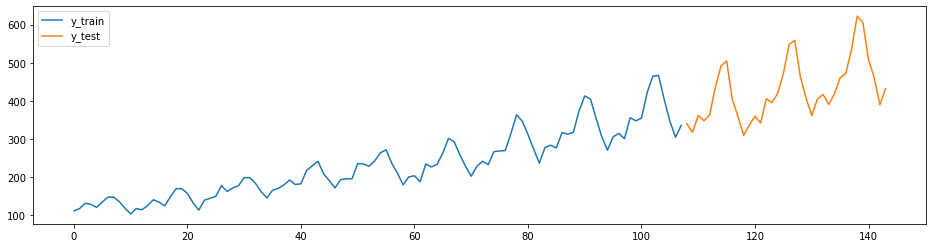

In [51]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])

In [58]:
type(y)

pandas.core.series.Series

TypeError: 'numpy.ndarray' object is not callable

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1aa0b05f080>)

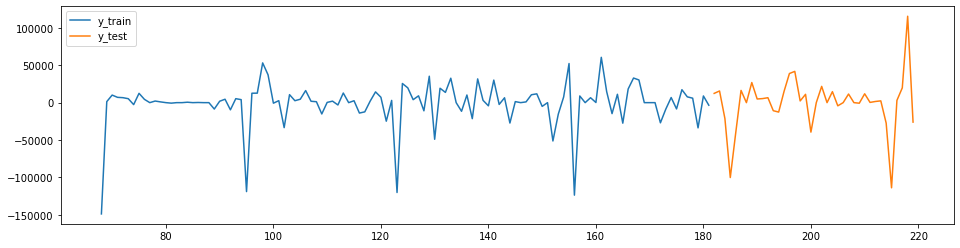

In [206]:
y_train, y_test = temporal_train_test_split(month_subset_new["amount_cents"])
plot_ys(y_train, y_test, labels=["y_train", "y_test"])

In [207]:
y_test

created_at_PMT
182     12375
183     15608
184    -21361
185   -100161
186    -41090
187     16360
188         0
189     26890
190      4894
191      5409
192      6593
193    -10782
194    -12617
195     15007
196     38954
197     41825
198      2303
199     11129
200    -39432
201         0
202     21764
203         0
204     14690
205     -4249
206         0
207     11523
208         0
209      -749
210     11840
211       306
212      1564
213      2378
214    -27380
215   -113901
216      3000
217     19788
218    115566
219    -26042
Name: amount_cents, dtype: int64

In [46]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   created_at_PMT  124 non-null    datetime64[ns]
 1   amount_cents    124 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.9 KB


In [ ]:
# from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting.forecasting import plot_ys

"""User subset from main table"""
user_subset = test.PMT_categories_BA_PFA[test.PMT_categories_BA_PFA["plaid_account_id"] == "1635ob1dkQIz1QMjLmBpt0E36VyM96ImeyrgZ"]

subset_index = user_subset[["created_at_PMT", "amount_cents"]] # change index to datetime
subset_index = subset_index.set_index("created_at_PMT")        #

user_subset_timeframe = pd.DataFrame(subset_index.amount_cents.resample('D').sum())  # resample datetime
user_subset_timeframe.set_index(user_subset_timeframe.index.dayofyear, inplace=True) # 

# plotting
y_train, y_test = temporal_train_test_split(user_subset_timeframe["amount_cents"])
plot_ys(y_train, y_test, labels=["y_train", "y_test"])